### PROBLEM SOLVING SUMMARY

##### PROMBLEM STATEMENT

To predict if an image is relevant or not given a text query

##### DATA GIVEN

1. “id” : unique identifier for an image
2. “query” : text query, which is used to determine the relevance of an image
3. “url_page”: webpage where the image is found
4. “image_url” : the source image url of the image, this is the url for the image itself
5. “title”: title of the “url_page”
6. “alt”: alternate text for the image
7. “is_relevance”: 1 if image is relevant to the query, 0 otherwise

and other html tag fields surronding the image

ps: "“image_url” wasn't present but understood "src" is actually the url of the image and hence considered it as image url

###### APPROACH 

1. Pre-processed and cleaned the data set 
2. Built a base-line model and measure the accuracy
3. Further processing / techniques to improvise the model 

PS : Only the final steps may be shown here in the notebook. I didn't show all of the preprocessing steps or model evaluation steps to avoid confusion but I have explained in detail .

######  EXPLORATORY DATA ANALYSIS

Below are the text processing done on the data

- All the fiels were considered initially that can be used in the model
- Total number of records present in the data : 607844
- Total number of features : 23
- No duplicates found in the data

- Feature selection & Engineering
    - 9 features had more than 80% of missing values and were dropped (Features mentioned in EDA)
    - After heuristicallly examining the data and doing some basic stats, text in 6 of the features are not relevant to the image . Hence 6 features were dropped
    - 'url_page' showed a more generic description of the image compared to the 'src' . And hence it was dropped too
    - 'text' feature did show a lot of relavance to the image and hence it was retained. 
    - A new feature 'combined_text' feature was formed to concatenate all the text features together
    - Initally , only 'query', 'src', 'title', 'alt' were concatenated together but later after including 'text' the model performed better . A total of 5 features were selected from the data and combined as an input for the model
    
- Text preprocessing
    -  Conversion of text to lowercase, removal of punctuations, extra characters, digits , single characters and extra whitespaces were done on the data
    - Since it's a classification problem, there weren't any need for stopwords and hence it wasremoved 
    - Lemmatization function is written but it took time to run and hence included in 'Next steps"
    
Issue: Initially the features were combined and preprocessed together but it took a lot of time to process
Resolve : So analysed the word count of each of the 5 features and found 'text' and 'alt' had maximum number of word count. So processed them individually and concatenated later

There  is a 35% percent decrease in word count after text preprocessing steps.

- Class imbalance
    - The class is higly imbalanced. 96% of the data pointed that the image is irrelavant (class : 0) while only the rest 4% had said it was relevant (class : 1) 
    
- Initally TF-IDF was applied to vectorize the data

###### BASELINE MODEL

- A logistic regression model was built after the above text processing steps and roc_auc_score was 53.9%
- Alternatively, Naivebase classifier and XG boost were also built 
     - Naive Bayes score is : 50.0%
     - XG boost score is : 53.2%
 
PS: since the accuracy metric was given already , only used roc_auc_score to measure model performance.

- Resolving strategies : Two main things were handled to improve the accuracy 
    - Embeddings :  Trying to see if the semantic meaning of the words in the text can be used . Also if the pre and post words in the sentences makes adds meaning to the data
    - Handling model imbalance

###### IMPROVISATIONS AND ISSUES

- Below are the improvising steps that were handled (included those that didn't work out too)
- Working with the data imbalance   
   -  Tried StratiefiedShufllesplit , to make sure there are equal distributions on the train and set and didn't show any big difference in the model
    - Parameter tuned LR model using class_weight set to '{0:1,1:5}' , giving more weightage to 1 class. LR gave out an accuracy of 58%
    - Included 'text' field in the prediction , LR's performance rose up to 59.1%
    - Parameter tuned LR model using class_weight set to 'balanced' , giving more weightage to 1 class. LR gave out an accuracy of 66.9%. There is chance of overfitting and hence tried handling imbalance in boosting classifiers as well
- Working with features
    - Tried to extract Semantinc meaning of the text in the data and hence word2vec was applied inplace of tf-idf for vectorization. But didn't show any major improvement but only decreased the model performance.
    - Since BERT helps machine learn excellent reperesentations of text with respect to text context, tried to use BERT. But I was't able to install 'tensorflow-text' library in my machine(macbook pro M1 chip) and when i degraded the the tensorflow version to 2.9 , it popped errors to import the module. Spent more than half day trying to set up the configuration and hence dropped this idea
    - The next thing I tried was using LSTM , considering the nature of the  image decription that does have some continous text in it. I wrote the code for executing the LSTM but it ran for more than 8 hrs and hence dropped it as well considering the time constraint . 
    - The deep learning models took more than a day for configuration setup and running
    - Finally , Parameter tuned XGboost scale_pos_weight parameter with tf-idf to the optimum level after running it on multiple weights and it performed well with an accuracy of 74.3%
    
   
###### RESULTS

- Selected XGBoost classifier among all the models for prediction which gave roc_auc_score of 74.3%


###### NEXT STEPS
Considering the time for running and exploring, I would consider the following ideas as my next steps

- Try to add more features (extract the overall text in the url page and see if it is relevant to the image). Feature engineering more might actually help building the model accuracy with out adjusting the class balance
- Perform dimensionality reduction and capture the relationship between features. 
- Definitely if given access to the data, add in more data to handle class imbalance . Adding in more data would defintely help avoid overfitting
- Configure to run BERT and LSTM to make sure the better semantic meaning of the text in the data is captured.
- Hypyerparamater optimization on the selected features

In [1]:
###importing libraries
import pandas as pd
import numpy as np
import seaborn as sns

#for word embedding
import gensim
from gensim.models import Word2Vec

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier


# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#for handling imbalance in the dataset

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

In [2]:
#downloading the libraries for text processing
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [3]:
#optional settings for exploratory analysis
pd.set_option("display.max_colwidth", None)

###  INPUT OUTPUT FUNCTIONS

In [4]:
def read_input(file):
    """
    Reads input file into pandas dataframe
    file : path of the file
    return : pandas dataframe
    """
    input_file = pd.read_feather(file)
    return input_file

def write_to_csv(data, columns, filename):
    """
    write pandas dataframe to csv
    data: dataframe name
    columns: columns to be written to csv
    filename : name of the file
    """
    data[columns].to_csv(filename, index=False)
    return

### GENERAL PROCESSING FUNCTIONS

In [5]:
def drop_columns(data,list_of_cols):
    """
    drops the listed columns
    data : pandas dataframe
    list_of_cols : column list
    return : pandadataframe with dropped columns
    """
    data.drop(columns=list_of_cols, inplace = True)
    data
    
    
def convert_to_str(data, column_name):
    """
    convert a column to string type
    data : pandas dataframe
    column_name : name_of_column
    return : pandadataframe 
    """
    data[column_name] = data[column_name].astype(str)
    return data
    

### TEXT PROCESSING FUNCTIONS

In [6]:
def conv_to_str(input_file, column_name):
    """
    converts the feature to str
    input_file : pandas dataframe
    column_name : feature name
    return : connverted feature name as str type
    """
    input_file[column_name] = input_file[column_name].astype(str)
    return input_file


def preprocess(text):
    """
    It does the following in order:
    1.Converts text to lowercase
    2.Strips of leading, trailing white spaces
    3.Removes special characters
    4.Removes punctuations
    5.Removes extra white spaces
    6.Removes digits
    7.Removes any other whitespaces
    8.Remove other digit characters
    9.Remove single characters
    text: text to process
    return: clean text
    """
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'(^| ).( |$)',' ', text)
    return text


def remove_stopwords(text):
    """
    removes stopwords from the text
    text : text to process
    return: text with removed stopwords
    """
    a= [word for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(a)


def lemmatize(text):
    """
    Reduce the text to it's orginal form depending on it's tag
    text : text to process
    return : lemmatized text
    """
    
    wn = WordNetLemmatizer()
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    word_pos_tags = nltk.pos_tag(word_tokenize(text))
    a=[wn.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)


def all_preprocess(string):
    """
    Combines all the text preprocessing steps
    string: text to process
    return : clean text 
    """
    return remove_stopwords(preprocess(string))

### MAIN FUNCTION

In [7]:
if __name__ == "__main__":
    
    #read in the input data
    data = read_input('data/train.feather')
    test_data = read_input('data/test.feather')

## Exploratory data analysis - Basic statistics , Feature Engineering & Feature Selection

###### Total number of rows : 607844
###### No duplicates
###### Number of features : 23
###### 733 distinct queries
###### Features like 'crossorigin', 'ismap', 'loading', 'longdesc',' referrerpolicy', 'sizes', 'srcset', 'style', have more 80% of missing values (shown as below) in them and doesn't make sense to include in them in the model. Hence all of them are dropped 


In [8]:
data.isnull().sum() * 100 / len(data)

query              0.000000
url_page           0.000000
title              0.000000
source             0.000000
alt               15.009114
src                0.000000
crossorigin       99.947684
height            59.597693
ismap             99.998519
loading           80.367496
longdesc          99.758326
referrerpolicy    99.946697
sizes             89.308605
srcset            82.591257
width             57.822895
class             49.008298
style             87.183718
tree_path          0.000000
deg               30.277999
text_tag          30.277999
text              30.277999
id                 0.000000
is_relevant        0.000000
dtype: float64

In [9]:
# Drop columns
drop_columns(data, ['crossorigin', 'height', 'ismap', 'loading', 'longdesc', 'referrerpolicy', 'sizes', 'srcset','style'])

###### Features like 'width', 'class', 'deg', 'text_tag', 'tree_path' don't have any real information that can add value to the text description we want to build and hence are removed on heuristic basics

###### Text in 'url_page' is more specific compared to the 'source' feature and might only create more deviation from the prediction . Hence is removed

##### Feature 'text' add more descriptions to the exact image and hence it is retained


In [10]:
# Drop columns based on heuristics
drop_columns(data, ['width', 'class', 'deg', 'text_tag', 'tree_path', 'source'])

0    586007
1     21837
Name: is_relevant, dtype: int64


<Axes: ylabel='is_relevant'>

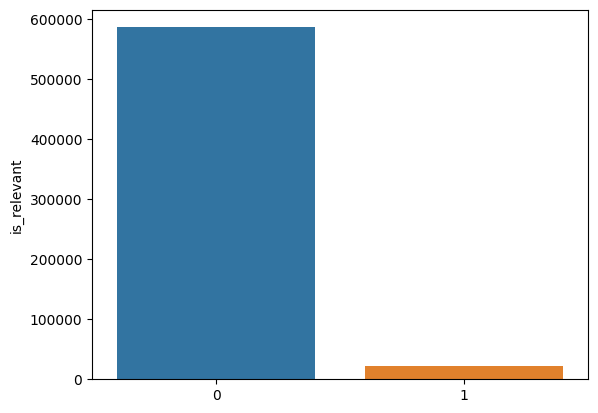

In [11]:
#Target feature distribution
print(data.is_relevant.value_counts())

sns.barplot(x=data.is_relevant.value_counts().index, y=data.is_relevant.value_counts())

#### data is imbalanced , there 96% of 0 compared to 1 , hence balancing techniques need to be applied while building the model

#### TEXT PREPROCESSING

In [12]:
# Preprocessing text 

#converting to str type for further processing
convert_to_str(data, 'alt')
convert_to_str(data, 'text')

#preprocessing all text columns
data['clean_query'] = data['query'].apply(lambda x: all_preprocess(x))
data['clean_title'] = data['title'].apply(lambda x: all_preprocess(x))
data['clean_src'] = data['src'].apply(lambda x: all_preprocess(x))
data['clean_alt'] = data['alt'].apply(lambda x: all_preprocess(x))
data['clean_text'] = data['text'].apply(lambda x: all_preprocess(x))
# Merge all of the text columns to form one feature variable for prediction
data['combined_text'] = data[['clean_query', 'clean_title', 'clean_alt', 'clean_src' ,'clean_text' ]].agg(' '.join, axis=1)

In [13]:
data['combined_text'] = data[['clean_query', 'clean_title', 'clean_alt', 'clean_src' ,'clean_text' ]].agg(' '.join, axis=1)

In [14]:
# word count
data['combined_text'].apply(lambda x: len(str(x).split())).describe()

count    607844.000000
mean        120.058800
std        1250.870275
min           6.000000
25%          22.000000
50%          29.000000
75%          41.000000
max       76553.000000
Name: combined_text, dtype: float64

##### TRAINING AND SPLITTING

In [17]:
# Input: "combined_text"
# Target: "is_relevant"

#Handling imbalance in the data 
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20,
                             random_state=0)

for train, test in splitter.split(data["combined_text"], data["is_relevant"]):
    X_train = data["combined_text"].iloc[train]
    y_train = data["is_relevant"].iloc[train]
    X_test = data["combined_text"].iloc[test]
    y_test = data["is_relevant"].iloc[test]
    
    

print(y_train.value_counts())
print(y_test.value_counts())

0    468805
1     17470
Name: is_relevant, dtype: int64
0    117202
1      4367
Name: is_relevant, dtype: int64


##### VECTORIZATION

In [18]:
#using tf-idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
#using word2vec

data['clean_text_tok']=[nltk.word_tokenize(i) for i in data['combined_text']]
w2v_model = gensim.models.Word2Vec(data['clean_text_tok'], vector_size=100, window=5, min_count=5, workers=4)
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors)) 

#embedding function to get the mean of all vectors
class MeanEmbeddingVectorizer(object):
    """
    Calculates the mean of all vectors of the words in a document
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [20]:
# Tokenizing the text
X_train_tok= [nltk.word_tokenize(i) for i in X_train] 
X_test_tok= [nltk.word_tokenize(i) for i in X_test]    

In [21]:
# Applying word2vec
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

##### MODEL BUILDING

#### LOGISTIC REGRESSION(TF-IDF)

In [22]:
# logistic regression model (Handling imbalanced dataset using class_weight)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

#fit the model
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Prediction
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Roc Auc Score: ", roc_auc_score(y_test, y_predict))

Confusion Matrix: [[116863    339]
 [  4013    354]]

 Roc Auc Score:  0.5390850361016941


In [23]:
# logistic regression model (Handling imbalanced dataset using class_weight)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight = 'balanced')

#fit the model
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Prediction
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Roc Auc Score: ", roc_auc_score(y_test, y_predict))

Confusion Matrix: [[106563  10639]
 [  2490   1877]]

 Roc Auc Score:  0.6695198082617667


#### NAIVE BAYES(TF-IDF)

In [24]:
# Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Prediction
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Roc Auc Score: ", roc_auc_score(y_test, y_predict))

Confusion Matrix: [[117164     38]
 [  4361      6]]

 Roc Auc Score:  0.5005248571857528


#### XG BOOSTING (TF-IDF)

In [25]:
#XGB model
xg_model = XGBClassifier()
xg_model.fit(X_train_vectors_tfidf, y_train)


# Creating the model on Training Data
y_predict = xg_model.predict(X_test_vectors_tfidf)
y_prob = xg_model.predict_proba(X_test_vectors_tfidf)[:,1]
 
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Roc Auc Score: ", roc_auc_score(y_test, y_predict))

Confusion Matrix: [[117113     89]
 [  4077    290]]

 Roc Auc Score:  0.5328238858929182


In [26]:
#Handling imbalance data using XGboost - parameter tunning
weights = [1, 10, 25, 50, 75, 99, 100, 1000]

for weigh in weights:
    #XGB model
    xg_model = XGBClassifier(scale_pos_weight=weigh)
    xg_model.fit(X_train_vectors_tfidf, y_train)


    # Creating the model on Training Data
    y_predict = xg_model.predict(X_test_vectors_tfidf)
    y_prob = xg_model.predict_proba(X_test_vectors_tfidf)[:,1]

    print ("when scale_pos_weight is :",weigh," Accuracy is :",roc_auc_score(y_test, y_predict))
    

when scale_pos_weight is : 1  Accuracy is : 0.5328238858929182
when scale_pos_weight is : 10  Accuracy is : 0.6574680765331586
when scale_pos_weight is : 25  Accuracy is : 0.7435707979186339
when scale_pos_weight is : 50  Accuracy is : 0.7334029948438979
when scale_pos_weight is : 75  Accuracy is : 0.7131189740984787
when scale_pos_weight is : 99  Accuracy is : 0.7003729304777009
when scale_pos_weight is : 100  Accuracy is : 0.7034619813100567
when scale_pos_weight is : 1000  Accuracy is : 0.6627074733103928


In [31]:
#XGB model (TF-IDF) 
final_xgbmodel_tfidf = XGBClassifier(scale_pos_weight=25)
final_xgbmodel_tfidf.fit(X_train_vectors_tfidf, y_train)


# Creating the model on Training Data
final_predict = final_xgbmodel_tfidf.predict(X_test_vectors_tfidf)
final_prob = final_xgbmodel_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print('Confusion Matrix:',confusion_matrix(y_test, final_predict))
print ("\n Roc Auc Score: ", roc_auc_score(y_test, final_predict))

Confusion Matrix: [[92896 24306]
 [ 1334  3033]]

 Roc Auc Score:  0.7435707979186339


#### XGBOOST (WORD2VEC)

In [28]:
final_model = XGBClassifier(scale_pos_weight=25)
final_model.fit(X_train_vectors_w2v, y_train)


# Creating the model on Training Data
final_predict = final_model.predict(X_test_vectors_w2v)
final_prob = final_model.predict_proba(X_test_vectors_w2v)[:,1]
 
print('Confusion Matrix:',confusion_matrix(y_test, final_predict))

print (roc_auc_score(y_test, final_predict))

Confusion Matrix: [[96038 21164]
 [ 1982  2385]]
0.6827821963287667


#### LOGISTIC REGRESSION (WORD2VEC)

In [29]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight = 'balanced')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Auc Score: ", roc_auc_score(y_test, y_predict))

Confusion Matrix: [[73720 43482]
 [ 1439  2928]]

 Auc Score:  0.6497413371758112


#### LSTM

In [36]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [37]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data['combined_text'].values)

# Pad the data 
X = tokenizer.texts_to_sequences(data['combined_text'].values)
X = pad_sequences(X, maxlen=2000)

In [38]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Metal device set to: Apple M1 Pro


2023-02-28 10:20:38.398888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 10:20:38.399058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 128)         256000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
Y = pd.get_dummies(data['is_relevant']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(486275, 2000) (486275, 2)
(121569, 2000) (121569, 2)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

##### The training takes more than 8 hours- so stopped it

In [ ]:
lstm_model = load_model('keras_model')

In [ ]:
y_predict_lstm = lstm_model.predict(X_test)

In [ ]:
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Auc Score: ", roc_auc_score(y_test, y_predict))

#### PREDICTING ON UNSEEN DATA

In [32]:
drop_columns(test_data, ['crossorigin', 'height', 'ismap', 'loading', 'longdesc', 'referrerpolicy', 'sizes', 'srcset','style', 'width', 'class', 'deg', 'text_tag', 'tree_path', 'source', 'url_page'])

In [33]:
# Preprocessing text 

#converting to str type for further processing
convert_to_str(test_data, 'alt')
convert_to_str(test_data, 'text')

#preprocessing all text columns
test_data['clean_query'] = test_data['query'].apply(lambda x: all_preprocess(x))
test_data['clean_title'] = test_data['title'].apply(lambda x: all_preprocess(x))
test_data['clean_src'] = test_data['src'].apply(lambda x: all_preprocess(x))
test_data['clean_alt'] = test_data['alt'].apply(lambda x: all_preprocess(x))
test_data['clean_text'] = test_data['text'].apply(lambda x: all_preprocess(x))
# Merge all of the text columns to form one feature variable for prediction
test_data['combined_text'] = test_data[['clean_query', 'clean_title', 'clean_alt', 'clean_src' ,'clean_text' ]].agg(' '.join, axis=1)

In [34]:
#vectorizing the input
test_data_vect = tfidf_vectorizer.transform(test_data['combined_text']) 

# Predicting on on the test data 
Y_test_data_predict = final_xgbmodel_tfidf.predict(test_data_vect)
y_test_data_prob = lr_tfidf.predict_proba(test_data_vect)[:,1]

In [35]:
# Converting the input to csv file
test_data['predict_prob']= y_test_data_prob
test_data['is_relevant']= Y_test_data_predict
final=test_data[['id','combined_text','is_relevant', 'predict_prob']].reset_index(drop=True)
write_to_csv(test_data, ['id', 'is_relevant'], "submission.csv")